## So sánh khi kết hợp HOG của nhóm + SVM so với HOG thư viện + SVM## 

In [14]:
import numpy as np
import glob2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import logging
import random
from numba import cuda
import math

In [15]:
from skimage import feature
def gray_host(input, channel):
    if channel==1:
        return
    return 0.299*input[:,:,0]+0.587*input[:,:,1]+0.114*input[:,:,2]

In [16]:
def read_data(link_cat, link_dog, n_samples, image_size = (128, 128), random_state = 42):
    list_cat = glob2.glob(link_cat)
    list_dog = glob2.glob(link_dog)
    cat_images = []
    cat_labels = []
    for i in range(int(n_samples/2)):
        if 'jpg' in list_cat[i]:
            img = Image.open(list_cat[i]).convert('RGB')
            img = img.resize(image_size, Image.LANCZOS)
            if len(np.array(img).shape) == 3:
                cat_images.append(np.array(img))
                cat_labels.append(1)
    dog_images = []
    dog_labels = []
    for i in range(int(n_samples/2)):
        if 'jpg' in list_dog[i]:
            img = Image.open(list_dog[i]).convert('RGB')
            img = img.resize(image_size, Image.LANCZOS)
            if len(np.array(img).shape) == 3:
                dog_images.append(np.array(img))
                dog_labels.append(-1)
    for index in range(len(cat_images)):
        if cat_images[index].shape[2] != 3:
            print(index, cat_images[index].shape[2])
    for index in range(len(dog_images)):
        if dog_images[index].shape[2] != 3:
            print(index, dog_images[index].shape[2])  
    cat_images = np.array(cat_images)
    cat_labels = np.array(cat_labels)
    dog_images = np.array(dog_images)
    dog_labels = np.array(dog_labels)
    
    x_cat_train, x_cat_test, y_cat_train, y_cat_test = train_test_split(cat_images, cat_labels, test_size=0.3, random_state = random_state)
    x_dog_train, x_dog_test, y_dog_train, y_dog_test = train_test_split(dog_images, dog_labels, test_size=0.3, random_state = random_state)
    X_train = np.concatenate((x_cat_train, x_dog_train), axis = 0)
    y_train = np.concatenate((y_cat_train, y_dog_train), axis = 0)
    X_test = np.concatenate((x_cat_test, x_dog_test), axis = 0)
    y_test = np.concatenate((y_cat_test, y_dog_test), axis = 0)

    s1 = np.arange(X_train.shape[0])
    random.Random(0).shuffle(s1)
    X_train = X_train.take(s1, axis = 0)
    y_train = y_train.take(s1, axis = 0)
    s2  = np.arange(X_test.shape[0])
    random.Random(5).shuffle(s2)
    X_test = X_test.take(s2, axis = 0)
    y_test = y_test.take(s2, axis = 0)
    
    return X_train, y_train, X_test, y_test

In [17]:
import HOG_CUDA_2 as CUDA

In [18]:
cell_size = (8, 8)
block_size = (2, 2)
nbins = 9
threadsperblock = (32,32)
hog_CUDA = CUDA.HOG(block_size, cell_size, nbins, 40,threadsperblock)

In [19]:
def big_fit(X_train, y_train, hog, svm):
    x_train = []
    t = 0
    for x in X_train:
        #print(t, end="  ")
        x_train.append(hog.compute_HOG(x))
        t+=1
    x_train = np.array(x_train)
    svm.fit(x_train, y_train)
    
def big_fit_LIB(X_train, y_train, svm):
    x_train = []
    t = 0
    for x in X_train:
        #print(t, end="  ")
        temp = gray_host(x,3)
        x_train.append(feature.hog(temp, orientations=9, pixels_per_cell=(8, 8), \
                cells_per_block=(2, 2), transform_sqrt=False, block_norm="L2",channel_axis=None))
        t+=1
    x_train = np.array(x_train)
    svm.fit(x_train, y_train)

    
    
def big_predict(X_test, y_test, hog, svm):
    x_test = []
    t = 0
    for x in X_test:
        #print(t, end = "  ")
        x_test.append(hog.compute_HOG(x))
        t+=1
    x_test = np.array(x_test)
    return svm.predict(x_test)

def big_predict_LIB(X_test, y_test, svm):
    x_test = []
    t = 0
    for x in X_test:
        #print(t, end = "  ")
        temp = gray_host(x,3)
        x_test.append(feature.hog(temp, orientations=9, pixels_per_cell=(8, 8), \
                cells_per_block=(2, 2), transform_sqrt=False, block_norm="L2",channel_axis=None))
        t+=1
    x_test = np.array(x_test)
    return svm.predict(x_test)

In [20]:
acc_HOG_C = []
time_HOG_C = []
acc_HOG_lib = []
time_HOG_lib = []

In [21]:
n_test = [100, 200, 300,400,600,1000]
link_cat = r'C:\Users\dolek\Documents\GitHub\Applied-Parallel-Programming\Main\Data\Cat\**'
link_dog = r'C:\Users\dolek\Documents\GitHub\Applied-Parallel-Programming\Main\Data\Dog\**'

In [22]:
import time
for n in n_test:
    #--------------------------------------------------------------------------------------------
    X_train, y_train, X_test, y_test = read_data(link_cat, link_dog, n)
    y_train_sklearn = np.array([str(y) for y in y_train])
    y_test_sklearn = np.array([str(y) for y in y_test])
    print("Lib",n)
    start = time.time()
    svm = SVC()
    big_fit_LIB(X_train, y_train_sklearn, svm)
    pred = big_predict_LIB(X_test, y_test_sklearn, svm)
    end = time.time()
    time_HOG_lib.append(end-start)
    acc_HOG_lib.append(accuracy_score(pred, y_test_sklearn))
    
    print("Cuda",n)
    start = time.time()
    svm = SVC()
    big_fit(X_train, y_train_sklearn, hog_CUDA, svm)
    pred = big_predict(X_test, y_test_sklearn, hog_CUDA, svm)
    end = time.time()
    time_HOG_C.append(end-start)
    acc_HOG_C.append(accuracy_score(pred, y_test_sklearn))
      

Lib 100
Cuda 100
Lib 200
Cuda 200
Lib 300
Cuda 300
Lib 400
Cuda 400
Lib 600
Cuda 600
Lib 1000
Cuda 1000


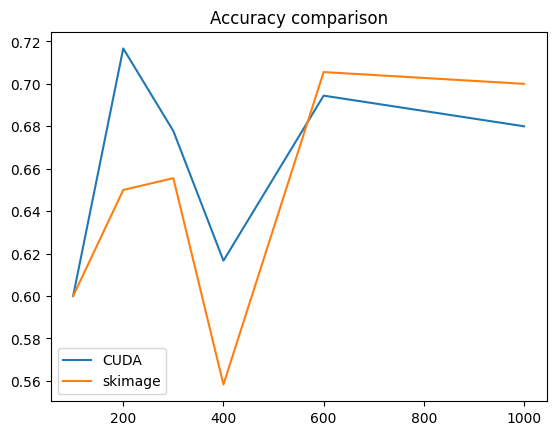

In [23]:
import matplotlib.pyplot as plt
plt.plot(n_test, acc_HOG_C, label = 'CUDA')
plt.plot(n_test, acc_HOG_lib, label = 'skimage')
plt.title("Accuracy comparison")
plt.legend()
plt.show()

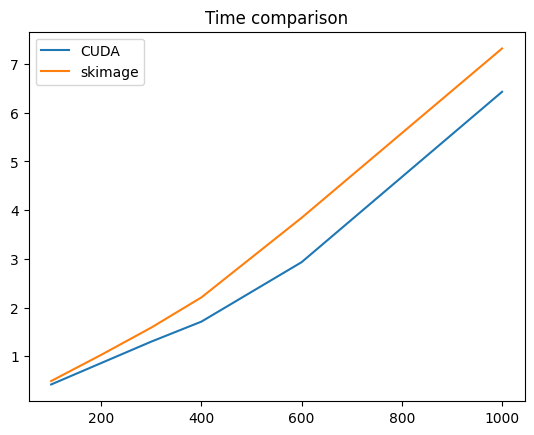

In [24]:
plt.plot(n_test, time_HOG_C, label = 'CUDA')
plt.plot(n_test, time_HOG_lib, label = 'skimage')
plt.title("Time comparison")
plt.legend()
plt.show()

Nhận xét:

- Trong thư viện thì border của direction và magnitude họ cho bằng 0. Và bước tính histogram họ có thực hiện thêm các bước mà bọn em không rõ lắm nên kết quả ra có sự khác biệt.
- Nhưng khi kết hợp chạy với SVM của thư viện sklearn thì thời gian khi kết hợp với HOG của nhóm tốt hơn rất nhiều so tới skicit-image
- Còn về độ chính xác thì bản của nhóm chiếm ưu thế với số mẫu ít (100, 200, 300, 400). Nhưng từ mẫu 600 thì skicit-image cao hơn một ít so với bản song song.